# XGBoost Demo test
The following is a model test which utilizes XGBoost on random values to showcase the core functionality of XGBoost,
 serving as a baseline for the f1_top3_predictor. It generates 100 binary decisiong trees with a max depth 
 of 5 nodes (including root and leaf). It uses a 0.1 learning rate (step) for Gradient Descent (GD). Model uses at
 most 80% of randomly selected rows and columns of each tree. This improves generalization and ensures  different 
 trees use a mix of different random features to make prediction (this way we don't have two or more trees comparing 
 the same thing)


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



## Pre-Modeling Observation
The following code uses a (100,5) dataframe and treats it as data and a (0,100) matrix and treats it as dummy labels. This includes some Pre-Modeling plots to showcase relationships between the features of the data such as correlation via heatmap. This is meant to unearth the hidden relationships inbetween features that may have otherwise been undiscovered without the visualization.

Total Explained Varience Ratio: 0.6935838018516425


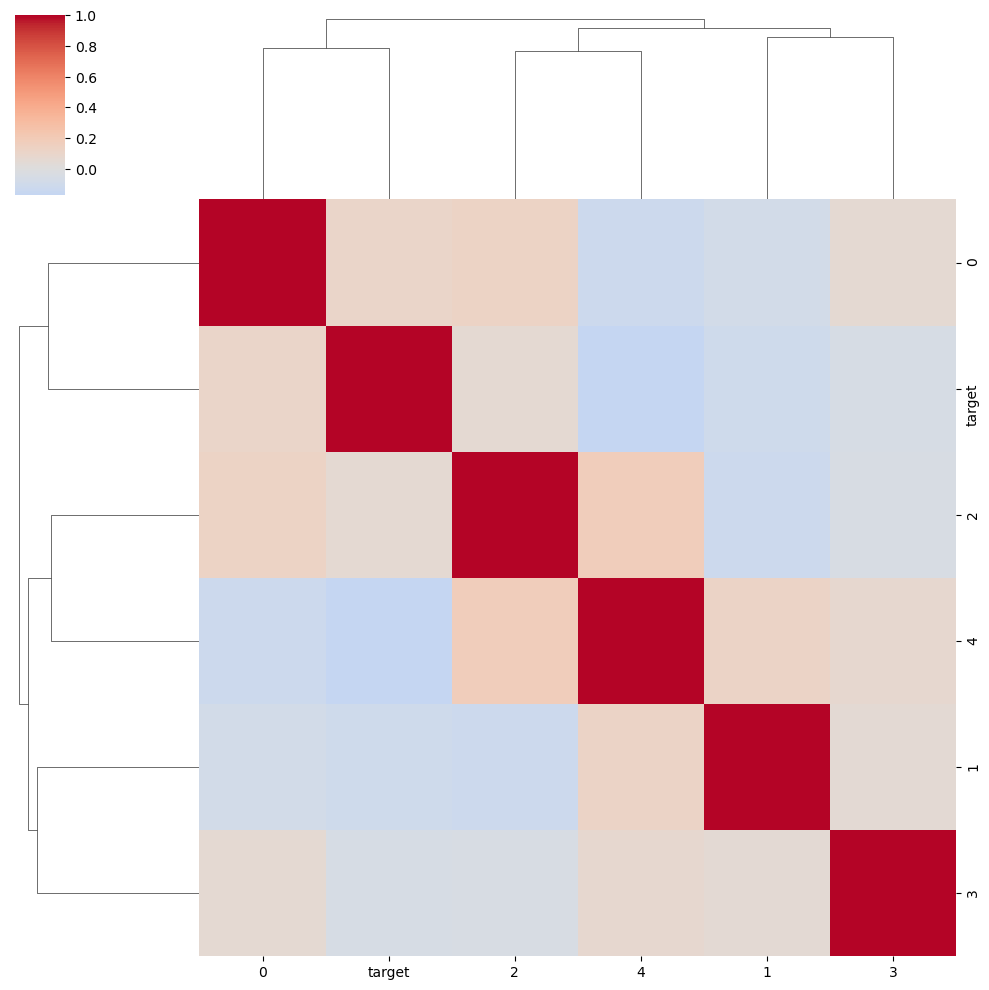

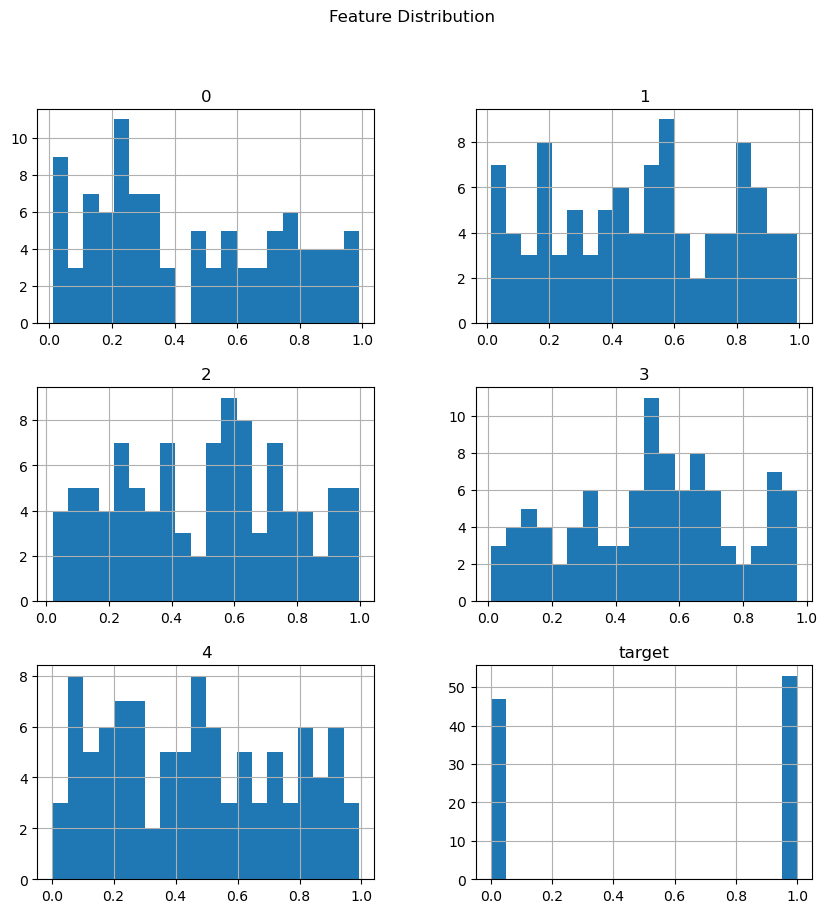

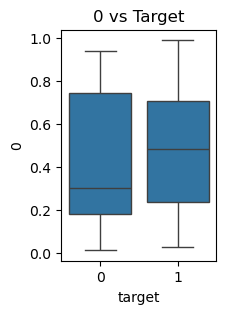

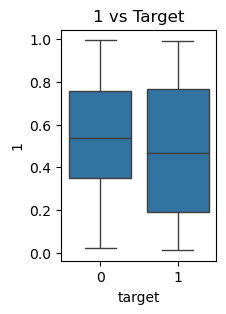

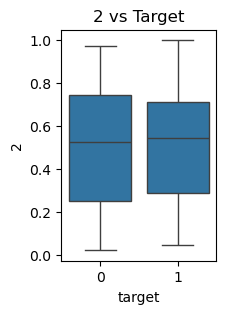

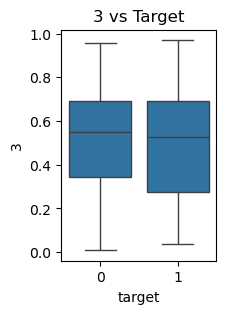

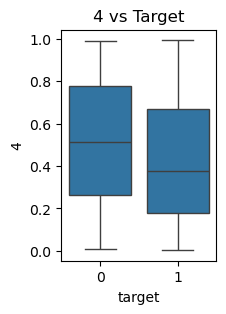

In [3]:
# dummy data to test
X = np.random.rand(100, 5)
feature_names = [f"{i}" for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=feature_names)

y = np.random.randint(0, 2, size = 100)
# Generates Correlation Heatmap 
df = X_df.copy()
df["target"] = y

# Generates Correlation Heatmap 
sns.clustermap(df.corr(), cmap="coolwarm", center=0)

# Generates Feature Distribution plots
df.hist(figsize=(10,10), bins=20)
plt.suptitle("Feature Distribution")

# Generates Boxplots by class
for col in X_df.columns:
    plt.figure(figsize=(2,3))
    sns.boxplot(x="target", y=col, data=df)
    plt.title(f"{col} vs Target")

# Generates 3D PCA with standardized features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Total Explained Varience Ratio:", pca.explained_variance_ratio_.sum())

df_pca = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "PC3": X_pca[:,2],
    "target": y
})

fig = px.scatter_3d(
    df_pca,
    x="PC1",
    y="PC2",
    z="PC3",
    color="target",
    opacity=0.7,
    title="Interactive 3D PCA Plot"
)

fig.show()


## XGBoost Training
The following code uses a (100,5) dataframe and treats it as data and a (0,100) matrix and treats it as dummy labels. We train an instance of XGBoost model on dataframe and print the accuracy score between predicted labels and real labels.

In [4]:

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state= 42)

# Simple XGBoost model
model = XGBClassifier(
    n_estimators = 100, #100 trees
    max_depth = 5, # max depth a tree can be
    learning_rate = 0.1, # stepsize when doing GD
    subsample = 0.8, # only gonna use randomly selected 80% of rows for each tree
    colsample_bytree = 0.8, #only gonna use randomly selected 80% of cols for each tree
    random_state = 42, #starting point for pseudorandomness
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6


## Observation plots
The following code plots:
* A Feature importance plot that showcases which features the XGBoost model saw as the most important in making prediction.
* I also shocases the first tree the model makes and the decisisons it makes at each node and the value contribution the leaves make to the prediction function (XGBoost uses prediction function
by using the values of all leaves it goes to in each tree and uses the to make a predition).
* It includes plots for shap values that showcase how each of the 5 features contribute prediction by visualizing their shap values at 
each row (keep in mind, for those in dark mode for VS Code, .force_plot with all shap values can't be changed to having a white background and isn't supported with matplotlib=True as of Nov 20 2025)

<Figure size 900x600 with 0 Axes>

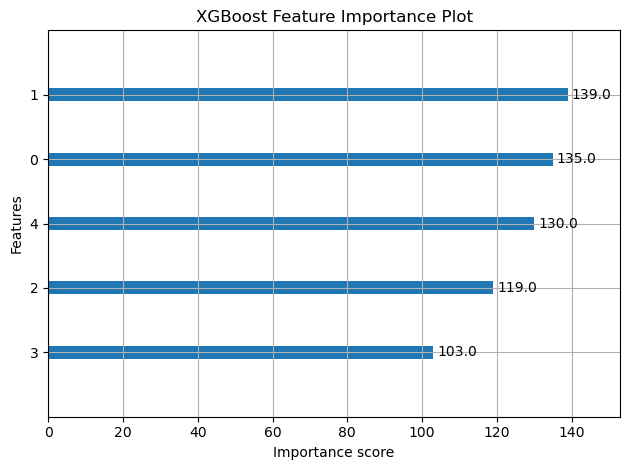

<Figure size 2000x1000 with 0 Axes>

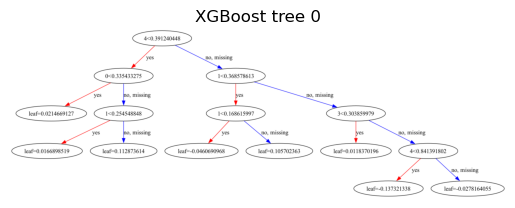

In [7]:
# Feature importance plot
plt.figure(figsize=(9, 6))
plot_importance(model)
plt.title("XGBoost Feature Importance Plot")
plt.tight_layout()
plt.show()

# Plots the first tree 
plt.figure(figsize=(20, 10))
plot_tree(model, tree_idx=0)
plt.title("XGBoost tree 0")
plt.show()

# Plots SHAP values for the features
shap.initjs()
explainer = shap.Explainer(model)
shap_values = explainer(X_df)
#shap.plots.heatmap(shap_values)
#shap.plots.waterfall(shap_values[0])
# shap.force_plot(shap_values[0])
shap.force_plot(shap_values[0: 100])

